In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

Importing plotly failed. Interactive plots will not work.


In [3]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [4]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [5]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [6]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures(include_emmergency_arrivals=True, include_nb_hospit=True),
    # ft.AirQualityFeatures,
    # ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    # ft.GoogleTrendFeatures,
    # ft.MeteorologicalFeatures,
    # ft.SociologicalFeatures,
    # ft.PopulationFeatures,
    # ft.SportsCompetitionFeatures,
    # ft.TrafficFeatures
    ]

In [7]:
# Select the target columns to be predicted
# target_colomns = ['nb_emmergencies']
target_colomns = ['nb_vers_hospit']
# target_colomns = ['target_nb_vers_hospit_CHU Dijon%%J+7%%mean_7J']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [8]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [9]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [10]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13efff280>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x111191840>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1111932b0>)],
                  verbose=True)

In [11]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [12]:
features_config_get = {}

In [13]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': 0,
    'targets_rolling_window': 0,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [14]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-29 11:49:26,795: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-29 11:49:26,807: INFO: Initialisation des features
root 2024-11-29 11:49:26,809: INFO: Fetching dataset
hospitalfeatures 2024-11-29 11:49:27,203: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-29 11:49:27,496: INFO: Getting the dataset from 01-01-2019 to 30-12-2023 for CHU Dijon
hospitalfeatures 2024-11-29 11:49:27,745: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
hospitalfeatures 2024-11-29 11:49:27,764: INFO: Augmentation des features...
root 2024-11-29 11:49:27,811: WARNING: Not shifting the target is not allowed as some features might not be available for today's date,                                            
as well as applying a positive shift as it would results in predicting the past                                            
Will use a default shift of -1 if targets_shift == 0 or of -targets_

Dropped 0 constant columns from both sets: set()
X shape: (1167, 2), y shape: (1167, 1)
[ColumnTransformer] .... (1 of 3) Processing pipeline-2, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing pipeline-3, total=   0.1s
[ColumnTransformer] .... (3 of 3) Processing pipeline-4, total=   0.1s


In [15]:
arsTabularDataset.targets_names[0]

'target_nb_vers_hospit_CHU Dijon%%J+1'

In [16]:
target_colomns = arsTabularDataset.targets_names[0]

In [17]:
df = arsTabularDataset.data

In [18]:
df = df.drop(df.loc['2020-03':'2020-05'].index)

In [19]:
df

,target_nb_vers_hospit_CHU Dijon%%J+1%%J-6,target_nb_vers_hospit_CHU Dijon%%J+1%%mean_31J%%J-1,nb_vers_hospit%%mean_7J,nb_vers_hospit%%mean_14J,nb_emmergencies%%std_14J,target_nb_vers_hospit_CHU Dijon%%J+1%%mean_7J%%J-1,target_nb_vers_hospit_CHU Dijon%%J+1%%J-2,nb_vers_hospit%%J-7,nb_emmergencies%%mean_365J,nb_vers_hospit%%std_14J,...,target_nb_vers_hospit_CHU Dijon%%J+1%%J-7,nb_vers_hospit%%std_7J,nb_emmergencies%%J-3,target_nb_vers_hospit_CHU Dijon%%J+1%%mean_365J%%J-1,location,nb_vers_hospit%%J-2,target_nb_vers_hospit_CHU Dijon%%J+1%%J-3,target_nb_vers_hospit_CHU Dijon%%J+1%%std7J%%J-1,target_nb_vers_hospit_CHU Dijon%%J+1%%std31J%%J-1,nb_vers_hospit
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,50.0,45.354839,46.142857,47.071429,13.998626,47.714286,50.0,46.0,192.476712,5.967402,...,50.0,3.023716,202.0,41.589041,CHU Dijon,46.0,50.0,5.089672,6.636005,46
2019-01-02,50.0,45.354839,46.142857,47.071429,13.998626,47.714286,50.0,46.0,192.476712,5.967402,...,50.0,3.023716,202.0,41.589041,CHU Dijon,46.0,50.0,5.089672,6.636005,50
2019-01-03,50.0,45.354839,46.142857,47.071429,13.998626,47.714286,50.0,46.0,192.476712,5.967402,...,50.0,3.023716,202.0,41.589041,CHU Dijon,46.0,50.0,5.089672,6.636005,44
2019-01-04,50.0,45.354839,46.142857,47.071429,13.998626,47.714286,44.0,46.0,192.476712,5.967402,...,50.0,3.023716,202.0,41.589041,CHU Dijon,50.0,50.0,5.089672,6.636005,49
2019-01-05,50.0,45.354839,46.142857,47.071429,13.998626,47.714286,49.0,46.0,192.476712,5.967402,...,50.0,3.023716,198.0,41.589041,CHU Dijon,44.0,44.0,5.089672,6.636005,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,41.0,40.064516,42.714286,40.642857,14.760543,43.142857,38.0,39.0,176.400000,4.908503,...,49.0,5.186980,182.0,38.558904,CHU Dijon,39.0,39.0,4.947342,5.144158,42
2023-12-26,51.0,39.935484,43.142857,40.500000,14.408483,41.428571,42.0,49.0,176.471233,4.831786,...,41.0,4.947342,198.0,38.526027,CHU Dijon,38.0,38.0,4.649629,5.170013,37
2023-12-27,42.0,39.806452,41.428571,40.428571,13.427052,40.714286,37.0,41.0,176.353425,4.878750,...,51.0,4.649629,177.0,38.526027,CHU Dijon,42.0,42.0,5.089672,5.218041,36


In [20]:
df[target_colomns]

date
2019-01-01    50.0
2019-01-02    44.0
2019-01-03    49.0
2019-01-04    41.0
2019-01-05    47.0
              ... 
2023-12-25    37.0
2023-12-26    36.0
2023-12-27    46.0
2023-12-28    44.0
2023-12-29    34.0
Name: target_nb_vers_hospit_CHU Dijon%%J+1, Length: 1732, dtype: float64

In [21]:
# arsTabularDataset.enc_data.to_csv('enc_data_hospit.csv')
# arsTabularDataset.data['nb_vers_hospit'].to_csv('target_hospit.csv')

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(df[target_colomns], model='additive', period=14)
df['trend'] = result.trend
df['resid'] = result.resid
df['seasonal'] = result.seasonal
df.dropna(inplace=True)

In [23]:
df['trend']

date
2019-01-08    46.357143
2019-01-09    46.750000
2019-01-10    46.964286
2019-01-11    46.821429
2019-01-12    46.357143
                ...    
2023-12-18    40.464286
2023-12-19    40.214286
2023-12-20    40.321429
2023-12-21    40.892857
2023-12-22    40.928571
Name: trend, Length: 1718, dtype: float64

In [24]:
df['resid']

date
2019-01-08    -6.133632
2019-01-09    -1.819462
2019-01-10    14.027809
2019-01-11     0.020550
2019-01-12    -9.281715
                ...    
2023-12-18     7.964800
2023-12-19     1.669504
2023-12-20    10.549876
2023-12-21    -2.671378
2023-12-22    -0.902795
Name: resid, Length: 1718, dtype: float64

In [25]:
df[target_colomns][-365:]

date
2022-12-23    36.0
2022-12-24    34.0
2022-12-25    49.0
2022-12-26    36.0
2022-12-27    49.0
              ... 
2023-12-18    49.0
2023-12-19    41.0
2023-12-20    51.0
2023-12-21    42.0
2023-12-22    39.0
Name: target_nb_vers_hospit_CHU Dijon%%J+1, Length: 365, dtype: float64

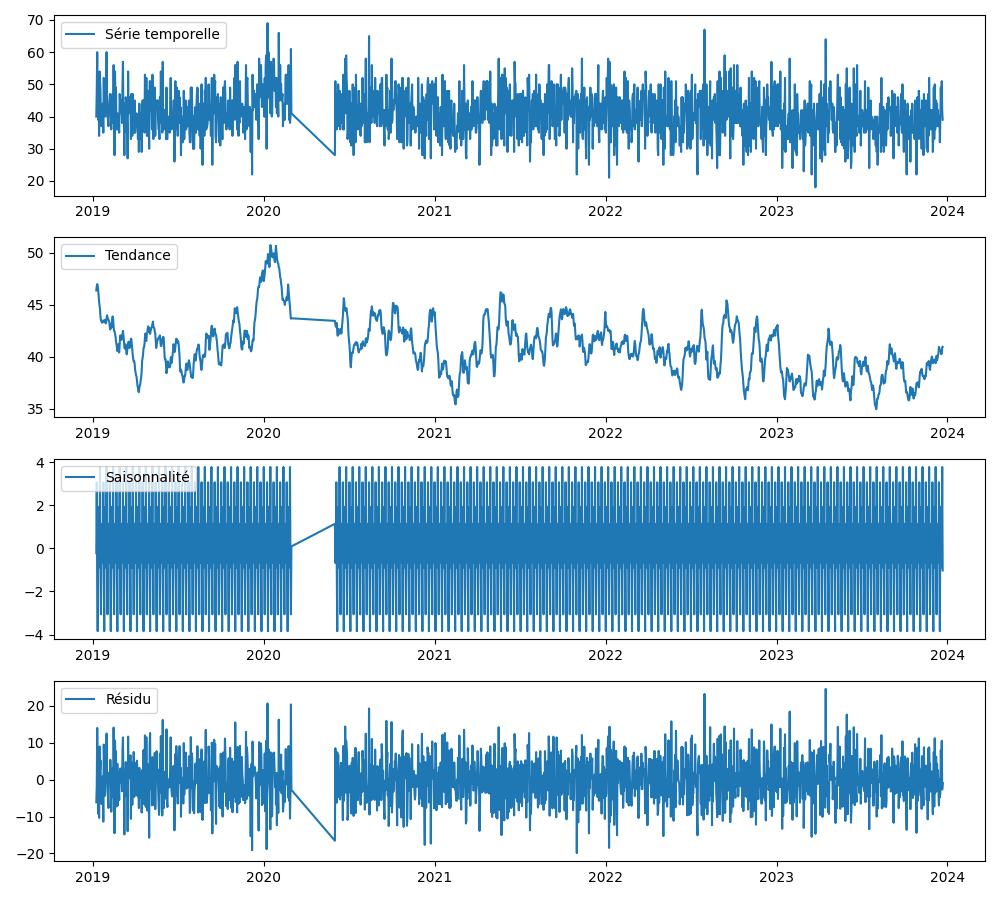

In [26]:
# Affichage des composantes
%matplotlib widget
plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.plot(df[target_colomns], label='Série temporelle')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(df['trend'], label='Tendance')
plt.legend(loc='upper left')


plt.subplot(413)
plt.plot(df['seasonal'], label='Saisonnalité')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(df['resid'], label='Résidu')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [27]:

# cible = []

# # p, d, q = 4,1,3
# # P, D, Q, m = 1,1,1,12
# p, d, q = order
# P, D, Q, m = seasonal_order
# N = 365
# for k in range(N):
#     # serie = df[target_colomns][:(-(N+15)+k)]
#     serie = df['trend'][:(-(N+15)+k)]
#     # print((-(N+15)+k))
#     # serie_exog = df['nb_emmergencies'][:(-(N+15)+k)]


#     # Définir le modèle ARMA (p, q à ajuster selon votre série temporelle)
#     #p, d, q =4,1,3
#     # modele = ARIMA(serie, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
#     # modele_fit = modele.fit()

#     modele = SARIMAX(serie, order=(p, d, q), seasonal_order=(P, D, Q, m))
#     modele_fit = modele.fit(disp=False)


#     # Prédiction des 15 prochains jours
#     pas_prevision = 15
#     prevision = modele_fit.forecast(steps=pas_prevision)

#     # Affichage des résultats
#     print(k, prevision.iloc[-1], (-(N+15)+k))
#     cible.append(prevision.iloc[-1])

In [28]:
def pred(df, column, nb_pred=365, step=1, model_type='SARIMAX', order=None, seasonal_order=None, recursive=False):
    if order is None:
        # Recherche des meilleurs paramètres ARIMA
        model_auto = auto_arima(df[column][:-nb_pred], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, m=7)
        # print(model_auto.summary())
        order = model_auto.order
        seasonal_order = model_auto.seasonal_order
    if recursive and step == 1: recursive = False
    list_preds = []
    p, d, q = order
    P, D, Q, m = seasonal_order
    # m = 7
    N = nb_pred
    
    for k in range(N):
        serie = list(df[column][:(-(N+(step+1))+k)].values)
        pred = []

        for l in range(step):
            # serie.append(list_preds[-(step-l)])
            if model_type == 'ARIMA':
                model = ARIMA(serie, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
            elif model_type == 'SARIMAX':
                model = SARIMAX(serie, order=(p, d, q), seasonal_order=(P, D, Q, m)) #, exog=df['nb_emmergencies'][:(-(N+(step+1))+k)].values)
                model_fit = model.fit(disp=False)
            
            if recursive:
                pred.append(model_fit.forecast(steps=1)[0])
                serie.append(pred[0])
            else:
                pred.append(model_fit.forecast(steps=step)[-int(step/2):])
                break
        
        # pred_value = list(pred)[-1]
        pred_value = np.mean(list(pred))
        print(k, pred_value)
        list_preds.append(pred_value)
    return list_preds

In [29]:
nb_pred = 365
step = 1
recursive = False
model = 'SARIMAX'

In [30]:
cible = pred(df, 'trend', nb_pred=nb_pred, step=step, model_type=model, order=None, seasonal_order=None, recursive=recursive)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1635.892, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1252.747, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1633.962, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1250.747, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1252.736, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=1123.647, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1125.631, Time=0.31 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=1125.317, Time=0.49 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(3,1,0)(0,0,0)[7] intercept   : AIC=1035.629, Time=0.19 sec
 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=1037.610, Time=0.41 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=1037.195, T

In [31]:
mean_absolute_error(cible, list(df['trend'][-nb_pred:].values))

0.663039852080941

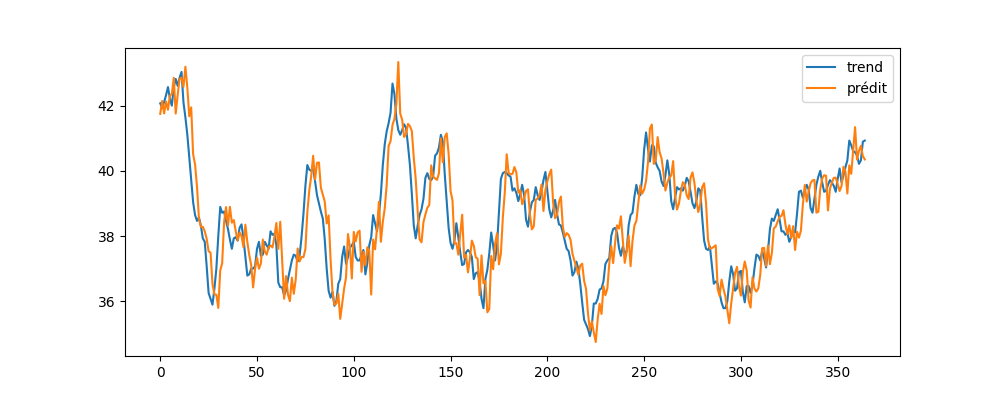

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(list(df['trend'][-nb_pred:].values), label='trend')
plt.plot(cible, label='prédit')
# df['trend'] = df['trend'].shift(16)
# plt.plot(df[target_colomns][-nb_pred:].values, label='tendance')
plt.legend()

In [33]:
cible_resid = pred(df, 'resid', nb_pred=nb_pred, step=step, model_type=model, order=None, seasonal_order=None, recursive=recursive)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8798.441, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=8776.764, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=8767.599, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=8796.441, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=8765.722, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=8767.580, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=8775.214, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,1)(0,0,0)[7]             : AIC=8763.722, Time=0.05 sec
 ARIMA(0,0,1)(1,0,0)[7]             : AIC=8765.580, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[7]             : AIC=8765.599, Time=0

In [34]:
pred = cible
pred = [a + b for a, b in zip(cible, cible_resid)]
pred = [a + b for a, b in zip(pred, df['seasonal'][-nb_pred:].values)]
# 'target_nb_vers_hospit_CHU Dijon%%J+7%%mean_7J'
reel = list(df[target_colomns][-nb_pred:].values)

In [35]:
mae = mean_absolute_error(pred, reel)
mae

4.759629846204934

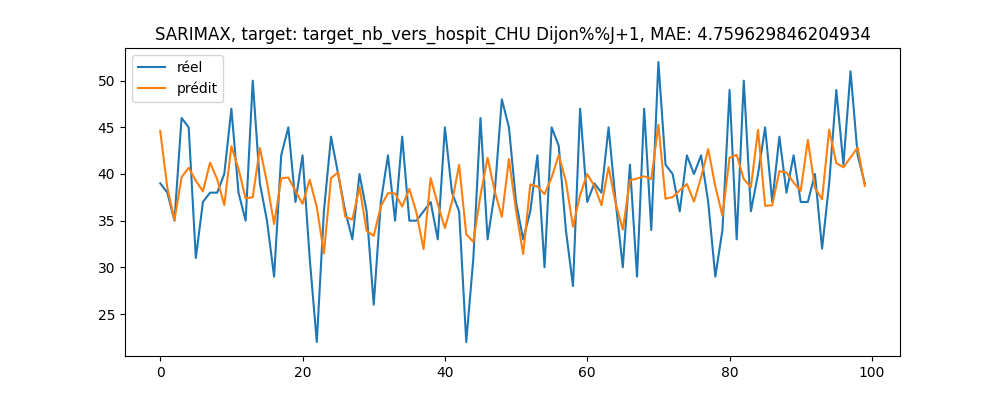

In [36]:
cut = 100
plt.figure(figsize=(10, 4))
plt.title(f'{model}, target: {target_colomns}, MAE: {mae}')
# plt.plot(list(df[target_colomns][-nb_pred:][-cut:].values), label='réel')
plt.plot(reel[-cut:], label='réel')
plt.plot(pred[-cut:], label='prédit')
# df['trend'] = df['trend'].shift(16)
# plt.plot(df[target_colomns][-nb_pred:].values, label='tendance')
plt.legend()